In [1]:
from ingest import DataFrame, Dataset
from ingred2vec import BatchedDataFrame
from train import IngredientsRBM

In [2]:
from torch.utils.data import DataLoader
import torch

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
from pickle import load, dump

#### Preprocess
Food.com dataset CSV available [on Kaggle](https://www.kaggle.com/datasets/realalexanderwei/food-com-recipes-with-ingredients-and-tags)


In [4]:
PATH = "/home/jovyan/d/datasets/foodcom_2023/share/recipes_ingredients.csv"
df = DataFrame(PATH)

  0%|          | 0/500471 [00:00<?, ?it/s]

  0%|          | 0/423760 [00:00<?, ?it/s]

In [5]:
df = df.df.sample(80*10**3)

In [8]:
df.head(n=1).T

,216181
id,114707
name,Toll House Chocolate Chip Cookies (Ca 1948)
description,This is from the re-print of the Toll House 19...
ingredients,"[brown sugar, white sugar, baking soda, hot wa..."
ingredients_raw,"[""1 cup butter"",""3/4 cup brown sugar""..."
steps,"[""Cream butter."", ""Add sugars."", ""Add eggs."", ..."
servings,1.0
serving_size,1 (1419 g)
tags,"[""30-minutes-or-less"", ""time-to-make"", ""course..."
sampled_words,"[chopped, nuts, vanilla, hot, water, brown, su..."


In [ ]:
BatchedDataFrame.save(df, batch_size=4)

#### Load

In [12]:
dataset = Dataset("./out/batches_0_4.job")

In [13]:
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=3, prefetch_factor=64)

In [14]:
mlb, _ = BatchedDataFrame.batches(df, batch_size=4)

In [13]:
# To give an idea for size of vector embeddings, as this depends on 
# preprocessing and sampling
len(mlb.classes_)

4632

#### Train for one epoch

In [16]:
VISIBLE_UNITS = len(mlb.classes_)
HIDDEN_UNITS = 12 * 10**3
CD_K = 12

In [17]:

rbm = IngredientsRBM(data_loader, VISIBLE_UNITS, HIDDEN_UNITS, CD_K, use_cuda=True)

rbm.fit(1, 4)


  0%|          | 0/16890 [00:00<?, ?it/s]

Epoch Error (epoch=0): 2297598.2500


Save Binarizer and RBM to pickle

In [ ]:
# with open("./out/rbm_dec22.pkl", 'wb') as fi:
#     dump(rbm, fi)

In [ ]:
# with open("./out/mlb_dec22.pkl", 'wb') as fi:
#     dump(mlb, fi)

In [9]:
with open("./out/rbm_dec22.pkl", 'rb') as fi:
    rbm = load(fi)

In [10]:
with open("./out/mlb_dec22.pkl", 'rb') as fi:
    mlb = load(fi)

#### Validate

Visualize embeddings of ingredients

In [12]:
flattened_ingreds = []

for u in df.dropna().sample(200).sampled_words.iloc[:200].to_list():
    flattened_ingreds += u

/home/alexander/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['a', 'b', 'c', 'd', 'e', 'f', 'h', 'i', 'k', 'm', 'p', 'r', 'u', 'v', 'w', 'y'] will be ignored
  warnings.warn(


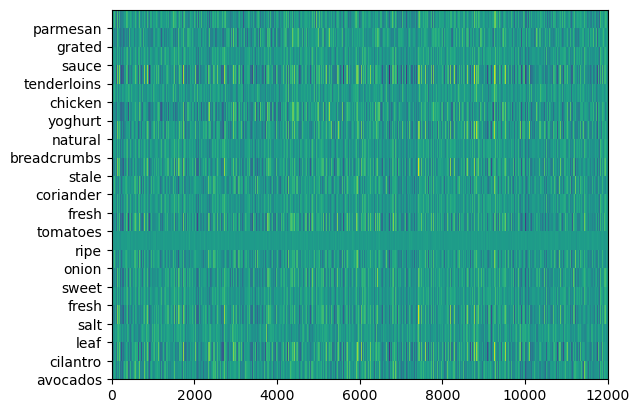

In [13]:
x = flattened_ingreds[:20]
%matplotlib inline
plt.pcolormesh(rbm.sample_hidden(torch.Tensor(
    mlb.transform(x)).cuda()).detach().cpu().numpy())
plt.yticks(ticks=list(range(len(x))),labels=x)
plt.show()

Visualize embeddings of ingredient groups (recipes)

In [14]:
x = df.dropna().sample(20).sampled_words

/home/alexander/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Mincemeat', 'crumbeled', 'fruitcake'] will be ignored
  warnings.warn(


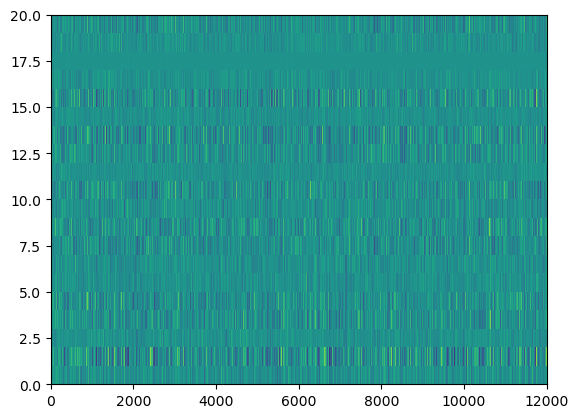

In [15]:
%matplotlib inline
plt.pcolormesh(rbm.sample_hidden(torch.Tensor(
    mlb.transform(x)).cuda()).detach().cpu().numpy())
plt.show()

Compute ingredient associations (mappings learned by RBM)

In [16]:
rbm.str_sample_hidden([["hamburger", "vanilla"],
                       ["parsley"]], mlb)

array([[0.4961942 , 0.49337527, 0.49013793, ..., 0.50107056, 0.5059768 ,
        0.5075918 ],
       [0.500144  , 0.49600106, 0.4941795 , ..., 0.50518596, 0.49762312,
        0.49050644]], dtype=float32)

In [17]:
rbm.str_predict([["olive"]], mlb, .2)

[('olive',)]

In [18]:
rbm.str_predict([["olive"]], mlb, .055)

[('icing', 'milk', 'olive', 'sherry')]

In [24]:
rbm.str_predict([["oil"]], mlb, .1)

[('olive',)]

In [25]:
rbm.str_predict([["canola", "oil"]], mlb, .1)

[('oil', 'olive')]

In [27]:
rbm.str_predict([["pineapple"]], mlb, .05)

[('icing', 'milk', 'pineapple', 'sherry')]

In [28]:
rbm.str_predict([["pineapple"]], mlb, .1)

[('pineapple',)]

In [29]:
flattened_ingreds = []

for u in df.dropna().sampled_words.iloc[:200].to_list():
    flattened_ingreds += u

In [31]:
np.array(mlb.transform([[u] for u in flattened_ingreds]))

/home/alexander/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['beemaid'] will be ignored
  warnings.warn(


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [32]:
flattened_ingreds[:12]

['chopped',
 'nuts',
 'vanilla',
 'hot',
 'water',
 'brown',
 'sugar',
 'white',
 'sugar',
 'baking',
 'soda',
 'shredded']